The data used in this notebook is from the MoneyVis dataset.
"Elif E Firat, Dharmateja Vytia, Navya Vasudeva, Zhuoqun Jiang, Robert S Laramee,
MoneyVis: Open Bank Transaction Data for Visualization and Beyond, Eurovis Short Papers,
Eurovis 2023, 12-16 June 2023, Leipzig, Germany,
https://doi.org/10.2312/evs.20231052, https://youtu.be/0tVzFK085gU"


In [3]:
# Libraries used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io

Load the dataset by altering `file_path_to_dataset` you can find the csv in the Github repository.

In [6]:
file_path_to_dataset = '/content/anonymized_original_with_category.csv'
df = pd.read_csv(file_path_to_dataset)

print("Data loaded successfully. Here are the first 5 rows:")
print(df.head())
print("\n--- Data Info ---")
df.info()

Data loaded successfully. Here are the first 5 rows:
   Transaction Number Transaction Date Transaction Type  \
0                   1       25/07/2022               BP   
1                   2       25/07/2022              DEB   
2                   3       25/07/2022              DEB   
3                   4       25/07/2022              DEB   
4                   5       25/07/2022              DEB   

  Transaction Description  Debit Amount  Credit Amount  Balance   Category  \
0         SAVE THE CHANGE          3.11            NaN   541.43    Savings   
1      LIDL GB  NOTTINGHA         15.02            NaN   544.54  Groceries   
2       NON-GBP PURCH FEE          0.50            NaN   559.56     Others   
3       NON-GBP TRANS FEE          0.37            NaN   560.06     Others   
4           TRAVELIUM LLC         12.59            NaN   560.43        NaN   

  Location City Location Country  
0    Nottingham               UK  
1    Nottingham               UK  
2    Nottingham   

Cleaning the dataset

In [7]:
# Convert 'Transaction Date' to datetime objects for time-series analysis
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], format='%d/%m/%Y')

# Handle missing numerical values. Debit and Credit are mutually exclusive, so we can fill NaNs with 0.
df['Debit Amount'] = df['Debit Amount'].fillna(0)
df['Credit Amount'] = df['Credit Amount'].fillna(0)

# Handle missing categorical values.
df['Category'] = df['Category'].fillna('Uncategorized')
df['Location City'] = df['Location City'].fillna('Unknown')
df['Location Country'] = df['Location Country'].fillna('Unknown')

# Create a single 'Amount' column for easier calculations.
# We'll make debits negative and credits positive.
df['Amount'] = df['Credit Amount'] - df['Debit Amount']

# Sort data by date to ensure chronological order for sequential analysis
df = df.sort_values(by='Transaction Date').reset_index(drop=True)

print(df.head())
print("--- Data Cleaning Complete ---")

   Transaction Number Transaction Date Transaction Type  \
0                6567       2015-07-27              FPO   
1                6566       2015-07-27              DEB   
2                6565       2015-07-27              DEB   
3                6564       2015-07-28               BP   
4                6563       2015-07-28              DEB   

  Transaction Description  Debit Amount  Credit Amount  Balance   Category  \
0            ALAN HOLLAND       1000.00            0.0  7517.06   Services   
1       JS ONLINE GROCERY        316.51            0.0  7200.55  Groceries   
2      Amazon UK Marketpl          6.39            0.0  7194.16     Amazon   
3         SAVE THE CHANGE          1.10            0.0  7193.06    Savings   
4      Amazon Svcs Europe          5.49            0.0  7187.57     Amazon   

  Location City Location Country   Amount  
0       Swansea               UK -1000.00  
1       Swansea               UK  -316.51  
2       Swansea               UK    -6.39  


Exploratory Data Analysis

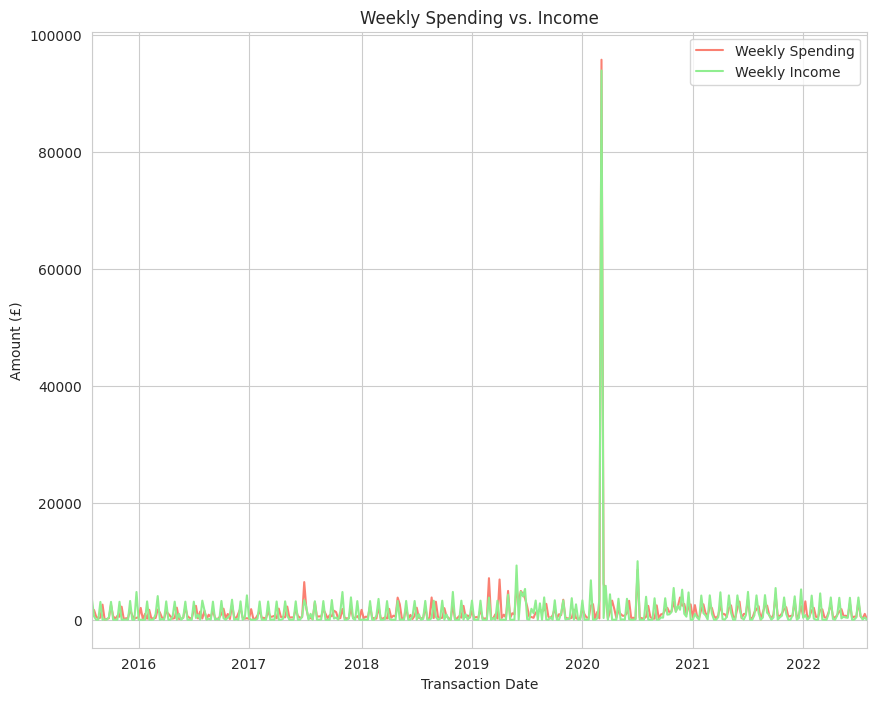

In [31]:
# Insight 1: Spending vs. Income Over Time
weekly_summary = df.set_index('Transaction Date').resample('W').agg({
    'Debit Amount': 'sum',
    'Credit Amount': 'sum',
    'Balance': 'last'
})

fig, ax = plt.subplots(figsize=(10, 8))

weekly_summary['Debit Amount'].plot(label='Weekly Spending', color='salmon')
weekly_summary['Credit Amount'].plot(label='Weekly Income', color='lightgreen')
plt.title('Weekly Spending vs. Income')
plt.ylabel('Amount (£)')
plt.legend()

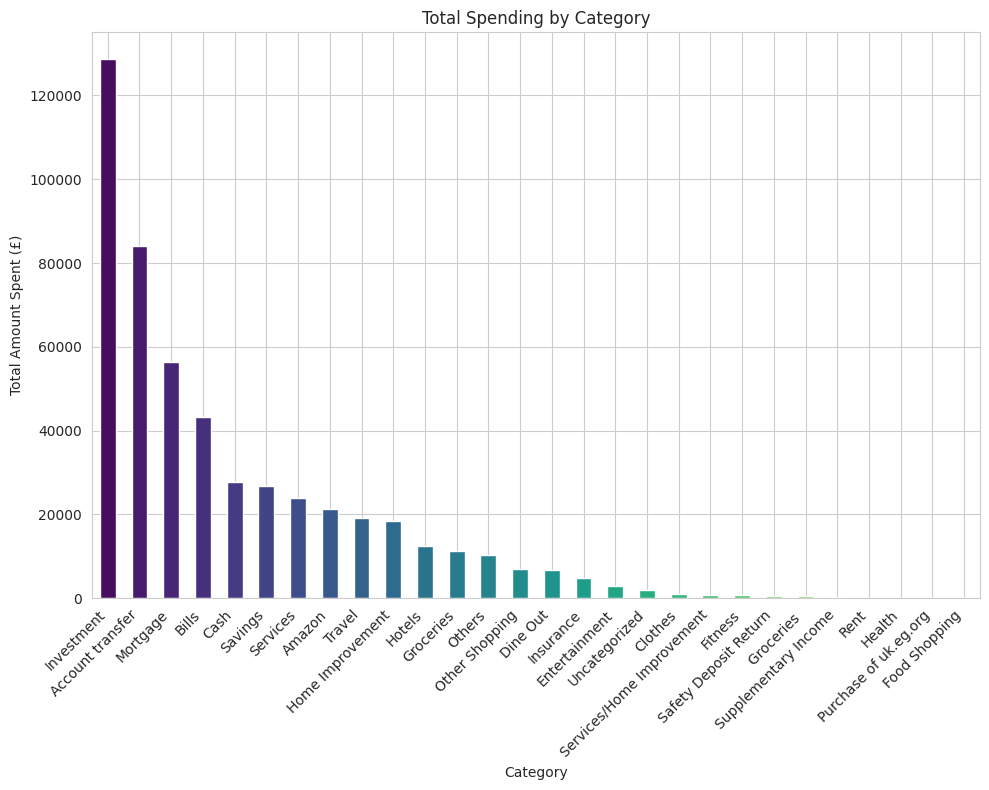

In [30]:
# Insight 2: Spending by Category
spending_categories = df[df['Amount'] < 0].groupby('Category')['Debit Amount'].sum().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))

spending_categories.plot(kind='bar', ax=ax, color=sns.color_palette('viridis', len(spending_categories)))
ax.set_title('Total Spending by Category')
ax.set_ylabel('Total Amount Spent (£)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Balance (£)')

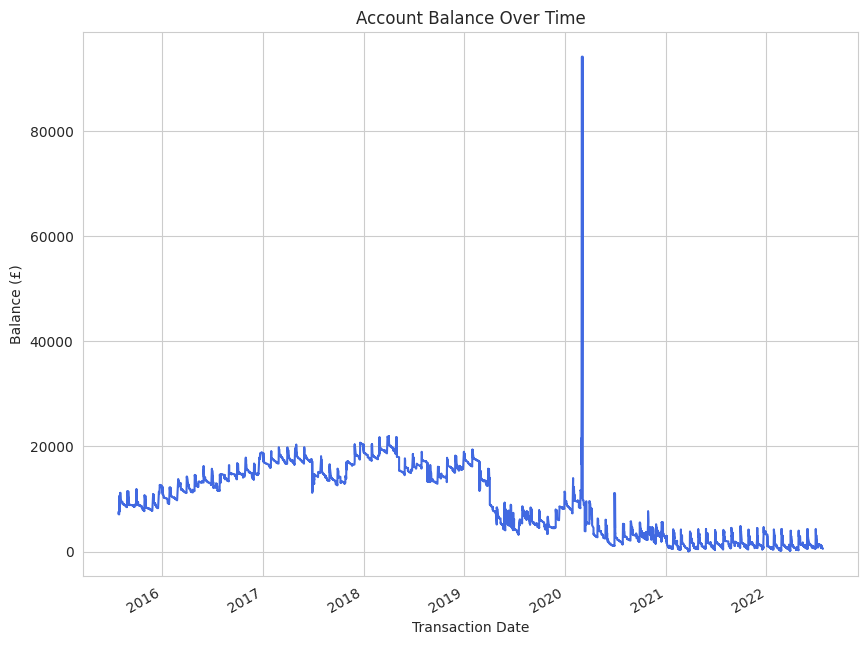

In [32]:
# Insight 3: Balance Fluctuation Over Time
fig, ax = plt.subplots(figsize=(10, 8))
df.plot(x='Transaction Date', y='Balance', ax=plt.gca(), legend=False, color='royalblue')
plt.title('Account Balance Over Time')
plt.ylabel('Balance (£)')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'DEB'),
  Text(1, 0, 'BP'),
  Text(2, 0, 'DD'),
  Text(3, 0, 'CPT'),
  Text(4, 0, 'FPO'),
  Text(5, 0, 'BGC'),
  Text(6, 0, 'SO'),
  Text(7, 0, 'FPI'),
  Text(8, 0, 'DEP'),
  Text(9, 0, 'PAY'),
  Text(10, 0, 'TFR'),
  Text(11, 0, 'FEE'),
  Text(12, 0, 'CHQ')])

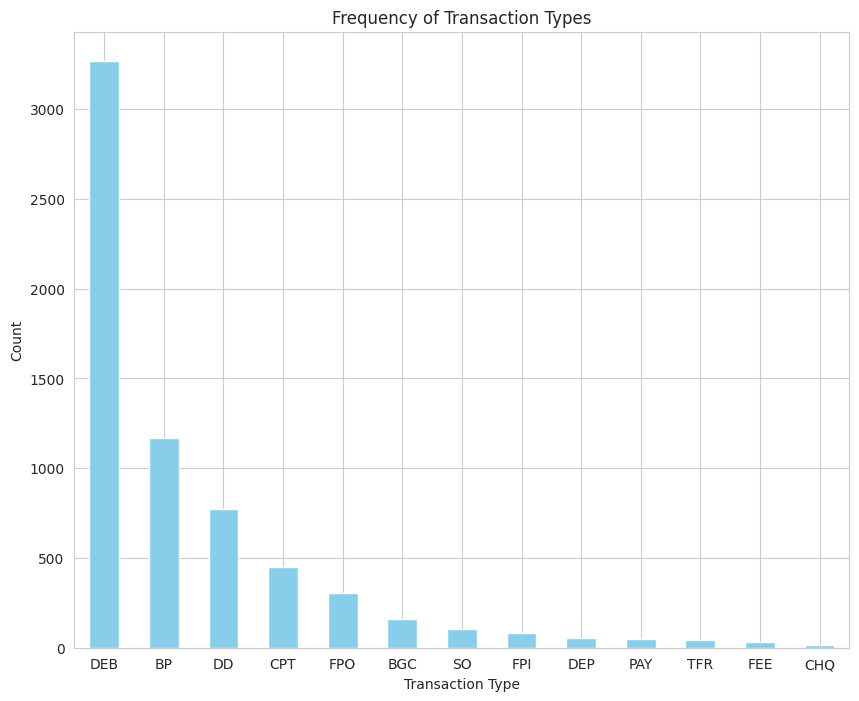

In [33]:
# Insight 4: Transaction Type Frequency
fig, ax = plt.subplots(figsize=(10, 8))
df['Transaction Type'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Frequency of Transaction Types')
plt.ylabel('Count')
plt.xticks(rotation=0)

In [36]:
print("\n--- Preparing Data for Reinforcement Learning ---")


# Step 4.1: Create the base weekly summary for primary financial metrics.
rl_df_base = df.set_index('Transaction Date').resample('W').agg(
    total_spending=('Debit Amount', 'sum'),
    total_income=('Credit Amount', 'sum'),
    end_balance=('Balance', 'last'),
    transaction_count=('Transaction Number', 'count')
).fillna(0)

# Step 4.2: Create a pivot table for weekly spending by category.
category_spending_weekly = df.pivot_table(
    index='Transaction Date',
    columns='Category',
    values='Debit Amount',
    aggfunc='sum'
).fillna(0)
# Resample the pivot table weekly to match the base summary.
category_spending_weekly = category_spending_weekly.resample('W').sum()
# Clean up column names to be valid feature names.
category_spending_weekly.columns = [f'spending_{col.lower().replace(" ", "_").replace("&", "and")}' for col in category_spending_weekly.columns]

# Step 4.3: Join the base summary with the category spending data.
rl_df = rl_df_base.join(category_spending_weekly, how='left').fillna(0)

print("\nWeekly RL DataFrame Head:")
print(rl_df.head())


--- Preparing Data for Reinforcement Learning ---

Weekly RL DataFrame Head:
                  total_spending  total_income  end_balance  \
Transaction Date                                              
2015-08-02               1485.87       3545.99      7590.62   
2015-08-09               1666.76        590.69      9501.11   
2015-08-16                539.07          0.00      8962.04   
2015-08-23                237.30          0.00      8787.34   
2015-08-30                359.91       3043.03     11407.86   

                  transaction_count  spending_account_transfer  \
Transaction Date                                                 
2015-08-02                       16                        0.0   
2015-08-09                       28                        0.0   
2015-08-16                       16                        0.0   
2015-08-23                       23                        0.0   
2015-08-30                       17                        0.0   

                 

In [ ]:
# --- Define State, Action, and Reward ---

# State (S): A snapshot of the user's financial health for a given week.
# It's a vector of features like [end_balance, total_spending, total_income, spending_by_category...].
# We will normalize these features later during model training.

# Action (A): A discrete set of actions our system can take.
# [0]: Do Nothing
# [1]: Send Spending Alert (e.g., "You're spending more on 'Dine Out' this month.")
# [2]: Suggest Budget (e.g., "Try to keep your 'Groceries' spending under £80 next week.")
# [3]: Nudge to Save (e.g., "You have extra cash, consider moving £50 to savings.")
# [4]: Positive Reinforcement (e.g., "Great job on saving this week!")

# Reward (R): The reward for an action at week `t` is calculated based on the outcome in week `t+1`.
# This is the core of modeling behavior change.

In [37]:

def calculate_reward(current_week, next_week, action):
    reward = 0
    # If we nudged to save and their balance increased more than their income
    if action == 3 and (next_week['end_balance'] - current_week['end_balance']) > next_week['total_income']:
        reward += 10
    # If we sent a spending alert and spending decreased
    if action == 1 and next_week['total_spending'] < current_week['total_spending']:
        reward += 5
    # Penalize if overall balance goes down
    if next_week['end_balance'] < current_week['end_balance']:
        reward -= 2
    return reward


# --- Generate Trajectories ---
# We create the (state, action, reward, next_state) tuples.
# Since we don't know what action a system *actually* took,
# we must simulate it. In a real offline RL project, this is a major challenge.
# For this notebook, we will assume a random action was taken each week to demonstrate
# the data structure. This is our "behavior policy."

trajectories = []
action_space = [0, 1, 2, 3, 4]

for i in range(len(rl_df) - 1):
    current_state_data = rl_df.iloc[i]
    next_state_data = rl_df.iloc[i+1]

    # For demonstration, assume a random action was taken.
    action_taken = np.random.choice(action_space)

    # Calculate reward based on the outcome of the next week.
    reward = calculate_reward(current_state_data, next_state_data, action_taken)

    # The state is the vector of financial features.
    state_vector = current_state_data.values
    next_state_vector = next_state_data.values

    trajectories.append({
        'state': state_vector,
        'action': action_taken,
        'reward': reward,
        'next_state': next_state_vector,
        'terminal': False # Assuming no terminal state in this continuous process
    })

# Convert to a DataFrame for easy saving and loading.
trajectories_df = pd.DataFrame(trajectories)

print(f"\nGenerated {len(trajectories_df)} weekly RL trajectories.")
print("Sample of generated trajectories:")
print(trajectories_df.head())

# Save for the next phase
trajectories_df.to_pickle('rl_trajectories.pkl')




Generated 365 weekly RL trajectories.
Sample of generated trajectories:
                                               state  action  reward  \
0  [1485.87, 3545.9900000000002, 7590.62, 16.0, 0...       3      10   
1  [1666.76, 590.6899999999999, 9501.11, 28.0, 0....       0      -2   
2  [539.07, 0.0, 8962.04, 16.0, 0.0, 49.800000000...       3      -2   
3  [237.29999999999998, 0.0, 8787.34, 23.0, 0.0, ...       3       0   
4  [359.91, 3043.03, 11407.86, 17.0, 0.0, 47.89, ...       3      -2   

                                          next_state  terminal  
0  [1666.76, 590.6899999999999, 9501.11, 28.0, 0....     False  
1  [539.07, 0.0, 8962.04, 16.0, 0.0, 49.800000000...     False  
2  [237.29999999999998, 0.0, 8787.34, 23.0, 0.0, ...     False  
3  [359.91, 3043.03, 11407.86, 17.0, 0.0, 47.89, ...     False  
4  [2579.31, 4.74, 8985.85, 27.0, 0.0, 91.6700000...     False  
